# QSAR inference model
<a href="https://colab.research.google.com/drive/1qgS_TLWl0URLR_INfzC4WSvsQXF1DruO?usp=drive_link" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @markdown **Execute this block to set-up your environment.<br>**
# @markdown This step will install all dependent packages and create a virtual environment that can run the QSAR model.
%%bash

export NCCL_ASYNC_ERROR_HANDLING=1
export OMP_NUM_THREADS=1

cd /content
GIT_REPO='https://github.com/LicoriceLin/Uni-Mol.git'
UNICORE_URL='https://github.com/dptech-corp/Uni-Core/releases/download/0.0.2/unicore-0.0.1+cu113torch1.12.0-cp310-cp310-linux_x86_64.whl'
WEIGHT_URL='https://github.com/dptech-corp/Uni-Mol/releases/download/v0.1/mol_pre_no_h_220816.pt'
if [ ! -f UNIMOL_READY ]; then
  wget -q ${UNICORE_URL}
  pip3 -q install "unicore-0.0.1+cu113torch1.12.0-cp310-cp310-linux_x86_64.whl"
  git clone -b main ${GIT_REPO}
  cd ./Uni-Mol/unimol
  python setup.py develop
  cd -
  pip install -q rdkit
  pip install -q biopandas
  pip install -q py3Dmol
  git clone https://github.com/sjtugrc/NMDA_demo.git
  wget -q ${WEIGHT_URL}

  touch UNIMOL_READY
fi

In [32]:
# @markdown **Execute this block to pre-process your data**<br>
# @markdown In the QSAR task, you need to upload a folder containing {train, valid, test}.csv, and assign its path to parameter `data_path`.<br>
# @markdown This step will convert the data you need to infer from the csv format to the lmdb format which is acceptable to the QSAR model.<br>
# @markdown - `data_path`: The path to store the data you need to analyze with the QSAR model <br>
# @markdown     - Trained model and results are stored in f'{data_path}'_result
# @markdown - `seed`: The random seed used to regulate the sampling process of the original data

data_path='/content/NMDA_demo/qsar_data' # @param {type:"string"}
task_type='regression'
num_classes=1
seed=2023 # @param {type:"string"}
cal_norm='--cal-norm'
loss_func="finetune_mse"
metric="valid_agg_rmse"

import os
os.chdir('/content')

!python NMDA_demo/preprocess.py --data {data_path} --seed {seed} --split {cal_norm}
norm_path=os.path.join(data_path,"norm.txt")

if data_path.endswith('.csv'):
  norm_path=data_path.replace('.csv','.norm')
else:
  norm_path=os.path.join(data_path,'.norm')
with open(norm_path,'r') as f:
  ls=f.readlines()
  mean=float(ls[0].strip('mean: '))
  std=float(ls[1].strip('std: '))
extra_paras=f"--customized-regression --mean '{mean}' --std '{std}' "

Generate lmdb data for Uni-Mol model
4it [00:00,  4.57it/s]
/content/NMDA_demo/qsar_data/test.lmdb process 4 lines
Generate lmdb data for Uni-Mol model
0it [00:00, ?it/s]failed to generate scaffold with smiles: O=C1C2=NC(C([R1])=O)=NN2C3=C(N1)C=C(Cl)C(N4C=C(C=O)C=C4)=C3 
failed smiles: O=C1C2=NC(C([R1])=O)=NN2C3=C(N1)C=C(Cl)C(N4C=C(C=O)C=C4)=C3 
6it [00:00,  6.10it/s]
/content/NMDA_demo/qsar_data/valid.lmdb process 5 lines
Generate lmdb data for Uni-Mol model
62it [00:09,  6.66it/s]
/content/NMDA_demo/qsar_data/train.lmdb process 62 lines
mean: 0.5052
std: 0.8843


In [33]:
# @markdown **Execute this block to train your own model.**<br>
# @markdown This step will fine-tune the Uni-Mol model based on the input data to get your model
# @markdown - `fintune_weight_path`: The path where the pre-trained model weights are located.
# @markdown - Other parameters are used to adjust the model training process, with a set of optimized values ​​by default.
import os, sys,shutil
fintune_weight_path='/content/mol_pre_no_h_220816.pt' # @param {type:"string"}
only_polar=0# @param {type:"number"}
batch_size=32 # @param {type:"number"}
epoch=1 # @param {type:"integer"}
keep_last_epochs=1 #@param {type:"integer"}

assert keep_last_epochs<=epoch, 'no enough epoch to keep!'
lr=1e-4# @param {type:"number"}
dropout=0.1# @param {type:"number"}
warmup=0.06# @param {type:"number"}

# freezed parameters
num_workers=0
n_gpu=1
local_batch_size=batch_size
conf_size=11
dict_name='/content/Uni-Mol/unimol/example_data/molecule/dict.txt'

#processing
update_freq=int(batch_size / local_batch_size)
_=(data_path.replace('.csv',''))
for i in ['train','valid']:
  f=os.path.join(_,f'{i}.lmdb')
  assert os.path.isfile(f),(f'missing required file:\n{f}.\n'
  ' preprocess needed maybe?')
data_dir,task_name=os.path.split(_)
if not data_dir:
  data_dir='.'
save_dir=os.path.join(data_dir,f'{task_name}_result')

os.environ['LOCAL_RANK'] = '1'

if os.path.isdir(save_dir):
  shutil.rmtree(save_dir)
os.makedirs(save_dir,exist_ok=True)
!python -m torch.distributed.launch --nproc_per_node=$n_gpu --master_port 10086 --use_env \
    $(which unicore-train) $data_dir --task-name $task_name --user-dir ./Uni-Mol/unimol \
    --train-subset train --valid-subset valid \
    --conf-size $conf_size \
    --num-workers $num_workers --ddp-backend=c10d \
    --dict-name $dict_name \
    --task mol_finetune --loss $loss_func --arch unimol_base  \
    --classification-head-name $task_name --num-classes $num_classes \
    --optimizer adam --adam-betas '(0.9, 0.99)' --adam-eps 1e-6 --clip-norm 1.0 \
    --lr-scheduler polynomial_decay --lr $lr --warmup-ratio $warmup --max-epoch $epoch \
    --batch-size $local_batch_size --pooler-dropout $dropout \
    --update-freq $update_freq --seed $seed \
    --fp16 --fp16-init-scale 4 --fp16-scale-window 256 \
    --log-interval 100 --log-format simple \
    --validate-interval 1 --keep-last-epochs $keep_last_epochs \
    --finetune-from-model $fintune_weight_path \
    --best-checkpoint-metric $metric --patience 20 \
    --save-dir $save_dir --only-polar $only_polar \
    --tensorboard-logdir $save_dir $extra_paras

/usr/local/lib/python3.10/dist-packages/torch/distributed/launch.py:181: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use-env is set by default in torchrun.
If your script expects `--local-rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
2023-07-01 03:10:28.493672: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 03:10:29.428682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
fused_multi_tensor is not installed corrected
fused_rounding is not installed corrected
fused

In [36]:
# @markdown **Execute this block to infer your data.**<br>
# @markdown This step will complete inference based on your model.

task_type='regression'
num_classes=1
new_data_path=f'{data_path}/test.lmdb'
infer_weight_path=f'{data_path}_result/checkpoint_best.pt'
only_polar=0
norm_path=f'{data_path}/.norm'
seed=2023
dict_name='/content/Uni-Mol/unimol/example_data/molecule/dict.txt'
batch_size=16


import pandas as pd
from glob import glob
import re,os,shutil
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, precision_recall_curve,
                average_precision_score, confusion_matrix, ConfusionMatrixDisplay)

def sort_key(s):
    match = re.match(r'([\w/]+checkpoint)((\d+)|(_.+))\.pt', s)
    if match:
        prefix = match.group(1)
        if match.group(2).startswith('_'):
            return (1, match.group(2))

        else:
            return (0, int(match.group(2)))
    return (2, s)

def split_testfile(test_file:str):
    _,subset=os.path.split(test_file)
    subset=subset.replace('.lmdb','')
    result_path=os.path.join(_,subset+'_result')
    data_path,task_name=os.path.split(_)
    return data_path,task_name,subset,result_path

def split_list_col(df:pd.DataFrame,column_to_split:str):
    where_column_to_split=df.columns.get_loc(column_to_split)
    column_data = df.pop(column_to_split)
    try:
      try:
        len_column_data=len(column_data[0])
      except:
        len_column_data=1
      split_columns = pd.DataFrame(column_data.tolist(),
                        columns=[f'{column_to_split}_{i + 1}'
                        for i in range(len_column_data)])
    except:
      import pdb;pdb.set_trace()
    df_out = pd.concat([df.iloc[:, :where_column_to_split],
                        split_columns, df.iloc[:, where_column_to_split:]], axis=1)
    return df_out

def get_csv_results(predict_path):
  predict = pd.read_pickle(predict_path)
  smi_list, predict_list,target_list = [], [], []
  for batch in predict:
      sz = batch["bsz"]
      infer_name='prob' if task_type=='classification' else 'predict'
      for i in range(sz):
        smi_list.append(batch["smi_name"][i])
        predict_list.append(batch[infer_name][i].tolist())
        target_list.append(batch['target'][i].tolist())
  predict_df = pd.DataFrame({"SMILES": smi_list, "predict": predict_list,"target":target_list})
  predict_df=split_list_col(predict_df,"predict")
  if task_type=='regression':
    predict_df=split_list_col(predict_df,"target")

  predict_df = predict_df.groupby("SMILES")[
      [i for i in predict_df if i !='SMILES']].mean().reset_index()
  predict_df.to_csv(predict_path.replace('.out.pkl','.full.csv'),index=False)

  if task_type=='classification':
    demo_predict_list = [i[1] for i in predict_list]
    demo_target_list = [i for i in target_list]
  else:
    demo_predict_list = [i[0] for i in predict_list]
    demo_target_list = [i[0] for i in target_list]
  demo_predict_df = pd.DataFrame({"SMILES": smi_list, "predict":demo_predict_list ,"target":demo_target_list})
  demo_predict_df = demo_predict_df.groupby("SMILES")[["predict","target"]].mean().reset_index()
  demo_predict_df.to_csv(predict_path.replace('.out.pkl','.csv'),index=False)
  return demo_predict_df



loss_func="finetune_mse"
conf_size=11

if task_type=='regression':
    with open(norm_path,'r') as f:
        ls=f.readlines()
        mean=float(ls[0].strip('mean: '))
        std=float(ls[1].strip('std: '))
    infer_extra_paras=f"--customized-regression --mean '{mean}' --std '{std}' "
else:
    infer_extra_paras=''

if new_data_path.endswith('.lmdb'):
  (test_data_path,test_task_name,
  test_subset,test_result_path)=split_testfile(new_data_path)
elif new_data_path.endswith('.csv'):
  _=new_data_path.replace('.csv','.lmdb')
  if not os.path.isfile(_):
    flags=f'-data {new_data_path} --seed {seed}'
    !python NMDA_deeplearning_example/preprocess.py $flags
  (test_data_path,test_task_name,
  test_subset,test_result_path)=split_testfile(_)
else:
  raise ValueError

id=os.path.basename(infer_weight_path).replace('.pt','')
flags=f'''--user-dir /content/Uni-Mol/unimol/unimol {test_data_path} \
  --task-name {test_task_name} --valid-subset {test_subset} \
  --results-path {test_result_path} \
  --num-workers 8 --ddp-backend=c10d --batch-size {batch_size} \
  --task mol_finetune --loss {loss_func} --arch unimol_base \
  --classification-head-name {test_task_name} --num-classes {num_classes} \
  --dict-name {dict_name} --conf-size {conf_size} \
  --only-polar {only_polar}  \
  --path {infer_weight_path}  \
  --fp16 --fp16-init-scale 4 --fp16-scale-window 256 \
  --log-interval 50 --log-format simple {infer_extra_paras}'''

!python /content/Uni-Mol/unimol/unimol/infer.py $flags

fname = infer_weight_path.split("/")[-2]
save_path = os.path.join(test_result_path,
        fname + "_" + test_subset + ".out.pkl")
tmp_save_path=save_path.replace(".out.pkl",f".{id}.out.pkl")
shutil.move(save_path,tmp_save_path)
infer_result=get_csv_results(tmp_save_path)

2023-07-01 03:12:21.825302: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 03:12:22.755139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
fused_multi_tensor is not installed corrected
fused_rounding is not installed corrected
fused_layer_norm is not installed corrected
fused_softmax is not installed corrected
2023-07-01 03:12:24 | INFO | unimol.inference | loading model(s) from /content/NMDA_demo/qsar_data_result/checkpoint_best.pt
2023-07-01 03:12:25 | INFO | unimol.tasks.unimol_finetune | dictionary: 30 types
2023-07-01 03:12:26 | INFO | unimol.inference | Namespace(no_progress_bar=False, log_interval=50, log_format='simple', tensorboard_logdir='', seed=1, cpu=False, fp16=True, bf16=False, b

                                              SMILES   predict    target
0          O=C1C2=NC(C(O)=O)=NN2C(C=CC(C#N)=C3)=C3N1  0.487238  0.342423
1        O=C1C2=NC(C(OCC)=O)=NN2C(C=CC(C#N)=C3)=C3N1  0.434260  1.342423
2  O=C1N2N=C(C(C(=O)O)=C2C3=C(N1)C=C(C(F)(F)F)C=C...  0.505016 -1.142668
3  O=C1N2N=C(C(C(=O)OCC)=C2C3=C(N1)C=C(C(F)(F)F)C...  0.448753  0.505150


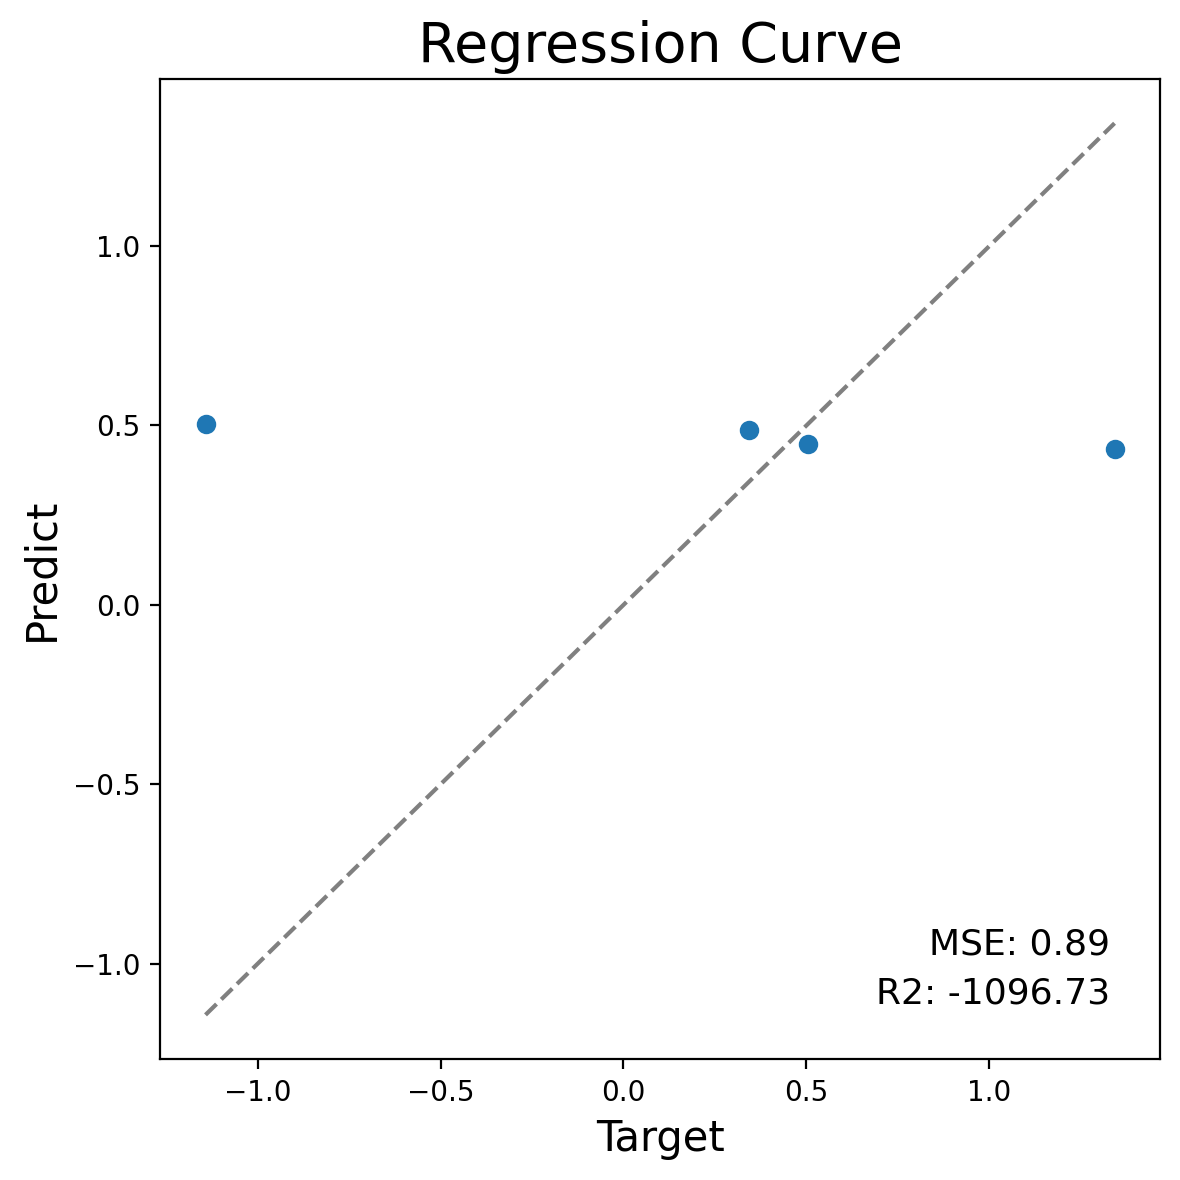

In [37]:
# @markdown **Execute this block to show your result and visualize your prediction.**<br>
# @markdown This step will display the first five rows of your results and visualize the results of the entire inference
print(infer_result.head(5))
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.scatter(infer_result['target'], infer_result['predict'])
min_max_ = [infer_result['target'].min(),infer_result['target'].max()]
axes.plot(min_max_,min_max_,'--',c='grey',label='x=y')

axes.set_xlabel('Target', fontsize=15)
axes.set_ylabel('Predict',fontsize=15)
r2 = r2_score(infer_result['predict'],infer_result['target'])
mse = mean_squared_error(infer_result['predict'],infer_result['target'])
axes.set_title("Regression Curve",fontsize=20)
plt.text(0.95, 0.1, f'MSE: {mse:.2f}', ha='right', va='bottom', transform=plt.gca().transAxes,fontsize=13)
plt.text(0.95, 0.05, f'R2: {r2:.2f}', ha='right', va='bottom', transform=plt.gca().transAxes,fontsize=13)
fig.set_dpi(200)
plt.tight_layout()
plt.show()